In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt

/Users/Konstantin_Perikov/projects/query-log-analytics/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embedder = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [3]:
## optional grouping if analytics provided is per entry
##
##
# corpus = pd.read_csv("query.csv",  error_bad_lines=False)
# grouped_by_query = corpus.groupby(['Query'], as_index = False).size().sort_values(by=['size'], ascending=False)
# print(grouped_by_query.head())
# grouped_by_query.to_csv("grouped_query.csv")


In [4]:
corpus = pd.read_csv("grouped_query.csv",  error_bad_lines=False)
corpus_embeddings = embedder.encode(corpus["Query"][:10000], show_progress_bar=True)

/var/folders/fq/8g9xnmjs40n0c4s8km55njvr0000gp/T/ipykernel_29909/324684343.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  corpus = pd.read_csv("grouped_query.csv",  error_bad_lines=False)
Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:24<00:00, 12.81it/s]


In [5]:
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [14]:
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [15]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []
    
    clustered_sentences[cluster_id].append(corpus.iloc[sentence_id].to_list())

print("Number of clusters ", len(clustered_sentences))  
print("==============================================")

sorted_clusters = []
t_total_sum = 0
for i, cluster in clustered_sentences.items():
    total_sum = 0
    for item in cluster:
        total_sum += item[2]
    sorted_clusters.append((cluster, i, total_sum))
    t_total_sum += total_sum
    
sorted_clusters = sorted(sorted_clusters, key = lambda x: -float(x[2]))
print(t_total_sum)

for cluster in sorted_clusters:
    data, i, total_sum = cluster
    print(f"""Cluster {i+1} size {total_sum} percentage {total_sum / t_total_sum}""")
    print(cluster)
    print("")
    print("==============================================")

Number of clusters  1036
936832
Cluster 577 size 102436 percentage 0.10934297718267523
([[305, '-', 98991], [1206706, 'y', 493], [286978, 'e', 420], [253325, 'dell', 387], [21959, 'a', 341], [806195, 's', 319], [147513, 'c', 310], [525, '.', 189], [239744, 'd', 165], [530084, 'l', 135], [679974, 'o', 109], [464145, 'i', 86], [952813, 'u', 78], [951781, 'ty', 64], [23, "'", 53], [73078, 'as', 51], [307204, 'es', 44], [557235, 'lo', 36], [422287, 'ho', 35], [1213081, 'ys', 35], [1213808, 'z', 34], [909249, 'the', 33], [39749, 'al', 28]], 576, 102436)

Cluster 232 size 49287 percentage 0.05261028658286651
([[386360, 'google', 32163], [386884, 'google.com', 7985], [1099262, 'www.google.com', 3981], [1099167, 'www.google', 1131], [1035599, 'www google.com', 554], [386729, 'google search', 322], [386447, 'google com', 309], [387247, 'googles', 229], [1202979, 'wwww.google.com', 201], [386863, 'google.co', 187], [1099242, 'www.google.co', 167], [1099239, 'www.google.cm', 136], [1099176, 'www.

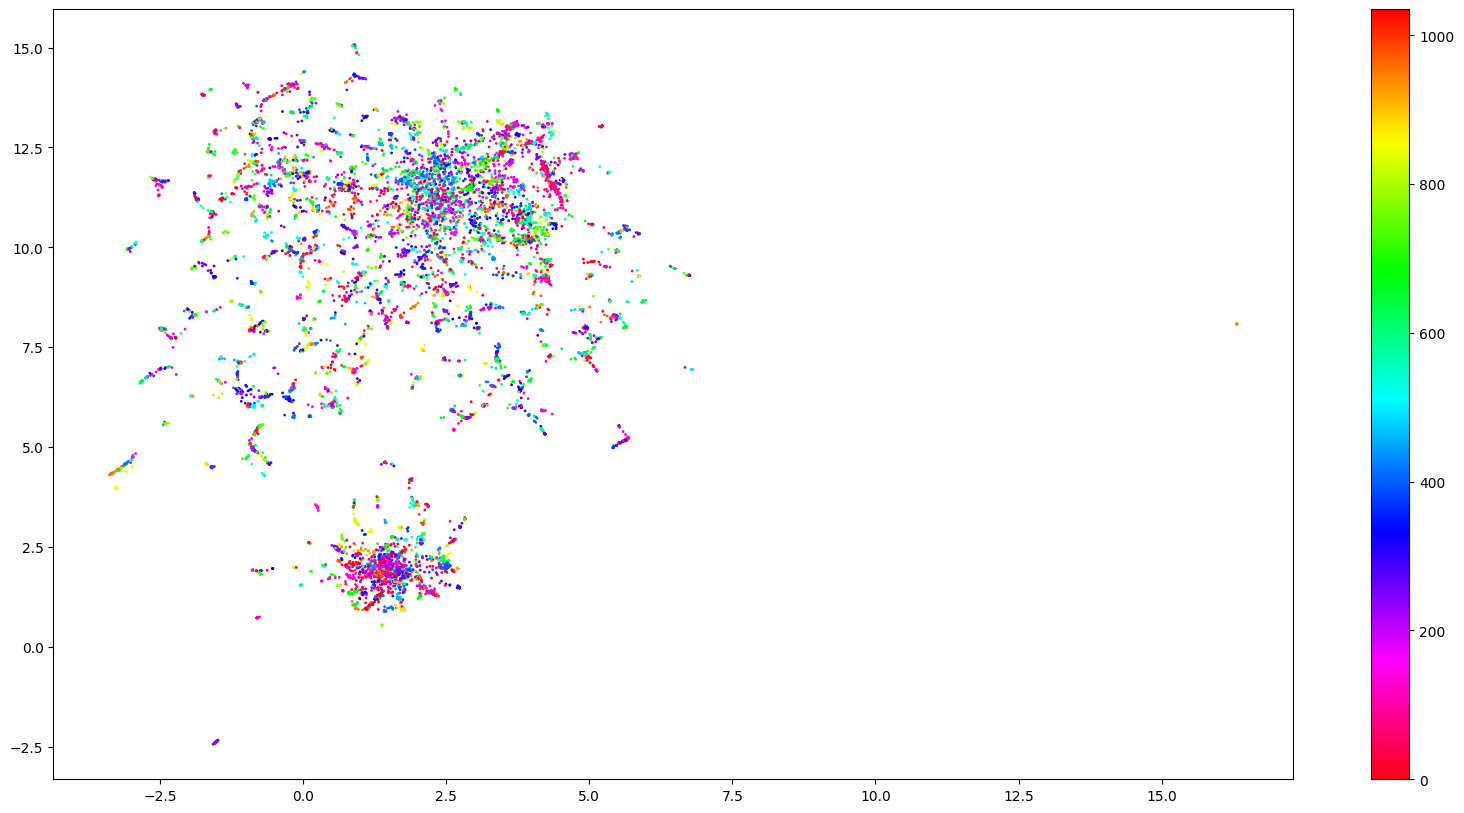

In [16]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clustering_model.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.colorbar()